### 진행 순서

- 데이터셋 **로드, 전처리** -> **토큰화** 하기 -> 트랜스포머's **모델 로드**, **훈련**, **추론** -> **모델 평가**
- 🤗데이터셋, 🤗토크나이저, 🤗트랜스포머 라이브러리 이용


### 데이터셋

[🤗데이터셋 docs🤗](https://huggingface.co/docs/datasets/index)

```py
load_dataset("파일 형식(csv,text,json 등..)", data_files="경로")

# ex 예시
load_dataset(
    "csv",
    data_files="file.csv",
    sep=";",
    name=["text","label"])
```

In [125]:
from datasets import load_dataset

dataset = load_dataset("emotion")

In [126]:
dataset # 아파치 애로우 형식 : 하나의 행이 하나의 딕셔너리

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

> 아파치 애로우 형식: 시스템과 프로그래밍 언어 간에 데이터를 효율적으로 교환할 수 있는 컬럼형 인메모리 데이터 형식

In [127]:
dataset['train']['text'][0]

'i didnt feel humiliated'

In [128]:
train_data = dataset['train']

In [129]:
len(train_data), 

(16000,)

### 데이터 셋 to Dataframe

In [130]:
import pandas as pd 

train_data.set_format(type="pandas")
df = train_data[:]

In [131]:
df['label_name'] = df['label'].apply(lambda x: train_data.features["label"].int2str(x))

In [132]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


### **데이터 클래스 분포 확인**

- 데이터 불균형 샘플링 기법
    - [📝내용 설명📝](https://github.com/tommyjin2894/ai_study?tab=readme-ov-file#%EC%83%98%ED%94%8C%EB%A7%81-%EA%B8%B0%EB%B2%95)
    - [🖥️상세 코드🖥️](https://github.com/tommyjin2894/ai_study/blob/main/code/00_basics/09_%EC%83%98%ED%94%8C%EB%A7%81.ipynb) 


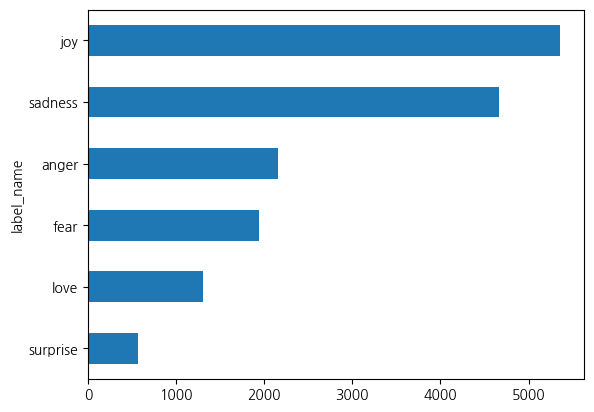

In [133]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh();

In [134]:
X = df.drop(columns=["label","label_name"])
y = df["label"]


In [135]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

In [136]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

ros = RandomOverSampler(random_state=42)
rus = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(train_x, train_y)
x_rous, y_rous = ros.fit_resample(x_ros, y_ros)

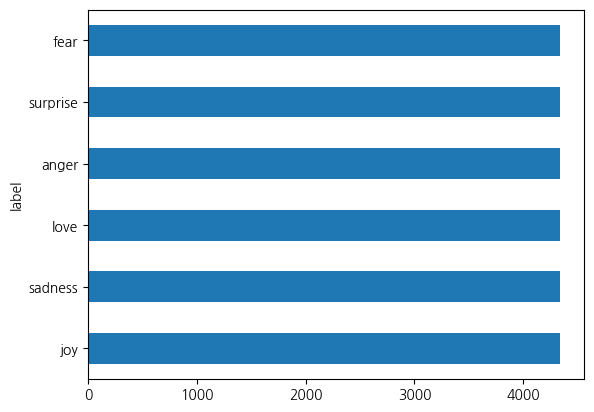

In [137]:
y_rous.apply(lambda x: train_data.features["label"].int2str(x))\
    .value_counts(ascending=True).plot.barh();

### 문장 길이 확인(최대 토큰 길이 측정)
- 간단하게 단어 기준으로 토큰화 진행

In [138]:
df["label_name"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [139]:
df['token_length'] = df['text'].str.split(" ").apply(lambda x:len(x))

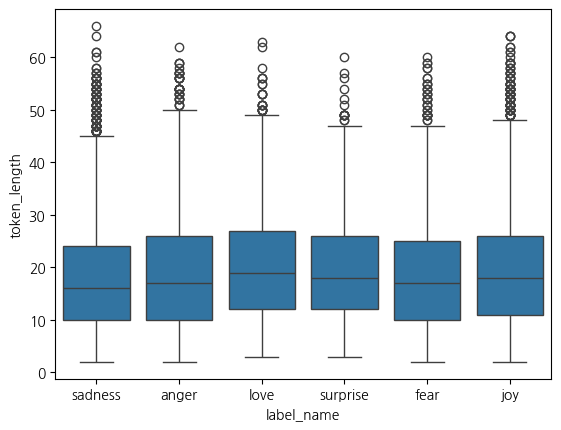

In [140]:
import seaborn as sns

sns.boxplot(data=df,
            x='label_name',
            y='token_length');

### 문장 토큰화 하기

In [141]:
words = set([word for sen in df['text'] for word in sen.split(" ")])
words = sorted(words)
words[1000:2000:100]

['bag',
 'battalion',
 'believers',
 'bikini',
 'blissed',
 'bombsite',
 'braided',
 'bruise',
 'bus',
 'canning']

In [142]:
token2idx = {ch: idx for ch, idx in enumerate(words)}
for i in range(1,16001,1001):
    print(f"index:{i:05}",token2idx[i])

index:00001 aa
index:01002 bagel
index:02003 castiel
index:03004 creates
index:04005 drew
index:05006 figured
index:06007 harder
index:07008 irresponcible
index:08009 machinery
index:09010 nobu
index:10011 plea
index:11012 reminisced
index:12013 shuts
index:13014 sumthg
index:14015 ugg
index:15016 worsen


- 참고) 원핫 인코딩 - to sparse 하다

In [143]:
import torch
import torch.nn.functional as F


for_ohi = torch.tensor(list(token2idx.keys()))

In [144]:
don_ohi = F.one_hot(for_ohi)
don_ohi

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

### 부분 단어 토큰화
- 단어 토큰화(5 : "hello", ...) + 문자 토큰화(5 : "h", ...)

- 모델에 맞는 토큰화 방법

In [145]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer_method = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer_method_1 = DistilBertTokenizer.from_pretrained(model_ckpt)

In [146]:
text_str = "Trolling is pretty annoying"

In [147]:
at_token = tokenizer_method(text_str)['input_ids']
print(at_token)

[101, 18792, 2075, 2003, 3492, 15703, 102]


In [148]:
reversed_token = tokenizer_method.convert_ids_to_tokens(at_token)
print(f'{reversed_token}')

['[CLS]', 'troll', '##ing', 'is', 'pretty', 'annoying', '[SEP]']


- [CLS] 문장의 시작,
- [sep] 문장의 분리를 의미,
- `##` 앞 문자열의 공간이 비어있지 않음

In [149]:
tokenizer_method.convert_tokens_to_string(reversed_token)

'[CLS] trolling is pretty annoying [SEP]'

- vocab 크기 확인

In [150]:
print('모델의 vocab 사이즈 :',tokenizer_method.vocab_size)
print('모델의 최대 길이 :',tokenizer_method.model_max_length)
print('모델의 필드 이름 :',tokenizer_method.model_input_names)

모델의 vocab 사이즈 : 30522
모델의 최대 길이 : 512
모델의 필드 이름 : ['input_ids', 'attention_mask']


### 전체 데이터 셋 토큰화

In [151]:
for i in dataset['train'][:3]['text']:
    print(i)

i didnt feel humiliated
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
im grabbing a minute to post i feel greedy wrong


In [152]:
tokenize = lambda batch : tokenizer_method([exam for exam in batch['text']],
                                           padding=True, truncation=True)
# test
tokenize(dataset['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [153]:
# all from datasets

all_datasets_toknized = dataset.map(tokenize, batched=True, batch_size=None)

In [154]:
all_datasets_toknized['train'][:2]

,input_ids,attention_mask
0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### DistilBERT 훈련하기

- transformers 는 tensorflow, Jax 에서 훈련된 사전 훈련 모델 사용이 가능하다.
    
    ```python
    from transformers import TFAutoModel
    tf_model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True)
    ```
    - Tensorflow의 모델을 불러와 자동으로 변환한다.


In [155]:
model_ckpt

'distilbert-base-uncased'

In [156]:
from transformers import AutoModel

device = torch.device("cuda")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [157]:
text = "test is fun!"
inputs = tokenizer_method(text, return_tensors='pt') # return_tensors = 옵션 ['pt', 'tf', 'np', 'jax', 'mlx']
inputs={k:v.to(device) for k,v in inputs.items()}
inputs

{'input_ids': tensor([[ 101, 3231, 2003, 4569,  999,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

- 필요한 인자 넘겨주기 `input_ids`, `attention_mask`

In [158]:
with torch.no_grad():
    outputs=model(**inputs)

outputs #named tuple 형태

BaseModelOutput(last_hidden_state=tensor([[[-3.2901e-02, -1.5536e-01,  6.7294e-02,  ..., -3.5374e-02,
           2.2140e-01,  3.0278e-01],
         [ 5.3307e-01, -1.2262e-01,  4.2616e-04,  ..., -3.5551e-01,
           3.7947e-01, -4.7466e-01],
         [-3.0976e-01, -1.6439e-01,  4.3289e-02,  ..., -1.1604e-01,
           1.2671e-01,  4.7686e-01],
         [-9.3830e-03, -1.9277e-01,  2.1580e-01,  ..., -1.1667e-01,
           8.4669e-02,  7.3999e-02],
         [-9.4883e-02, -4.1041e-01,  1.4524e-01,  ...,  2.6162e-01,
           2.6452e-01, -1.3557e-01],
         [ 9.4918e-01,  2.1852e-01, -3.9139e-01,  ...,  2.4219e-01,
          -4.7567e-01, -3.0236e-01]]], device='cuda:0'), hidden_states=None, attentions=None)

- [distilBERT](https://arxiv.org/pdf/1910.01108) 란?
    - BERT 대비 40% 작은 모델
    - 언어 이해 능력의 97% 유지
    - 60% 빠른 속도
    - triple loss method:
        - loss combining language modeling,
        - distillation
        - cosine-distance losses
        
    - 참고
        - [Knowledge Distilling](https://arxiv.org/pdf/1503.02531)
        - Task-specific distillation
        - [Multi-distillation](https://arxiv.org/pdf/2210.16103)

In [159]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

- 1 배치, 6 토큰, 768 차원의 임베딩 벡터

In [160]:
#각 6개의 토큰마다 768 차원의 임베딩 벡터
tokenizer_method.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]', 'test', 'is', 'fun', '!', '[SEP]']

### DistilBERT 예측 분류(machine learning head)

- 데이터셋 불러오기

In [161]:
from datasets import load_dataset

dataset = load_dataset("emotion")

- 모델 및 토크나이저 불러오기

In [162]:
from transformers import AutoTokenizer
from transformers import AutoModel
import torch

device = torch.device("cuda")

model_ckpt="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [163]:
tokenize = lambda batch : tokenizer([exam for exam in batch['text']],
                                           padding=True, truncation=True)

In [164]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

- hidden_state 추출

In [165]:
def extract_hs(batch):
    inputs= {k:v.to(device) for k,v in batch.items()
             if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        lst_hs = model(**inputs).last_hidden_state
    print(lst_hs)
    return {'hidden_state': lst_hs[:,0].cpu().numpy()}

In [166]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [167]:
emotion_hiddenstate = dataset_encoded.map(extract_hs, batched=True)

In [168]:
emotion_hiddenstate

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

- 특성 행렬 만들기

In [169]:
import numpy as np

x_train = np.array(emotion_hiddenstate['train']['hidden_state'])
x_valid = np.array(emotion_hiddenstate['validation']['hidden_state'])
y_train = np.array(emotion_hiddenstate['train']['label'])
y_valid = np.array(emotion_hiddenstate['validation']['label'])

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((16000, 768), (16000,), (2000, 768), (2000,))

In [170]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

x_scaled = MinMaxScaler().fit_transform(x_train)

mapper = UMAP(n_components=2, metric="cosine").fit(x_scaled)

In [171]:
import pandas as pd

df_emb = pd.DataFrame(mapper.embedding_, columns=["x","y"])
df_emb["label"] = y_train
df_emb.head(2)

,x,y,label
0,4.227810,6.512746,0
1,-3.239391,5.853460,0


- 라벨 별 시각화

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

cmaps = ["Greys","Blues","Oranges","Reds","Purples","Greens"]
mapping_cmaps = lambda x : cmaps[x]

df_emb['cmap']=df_emb['label'].map(mapping_cmaps)

In [173]:
labels = emotion_hiddenstate['train'].features['label'].names

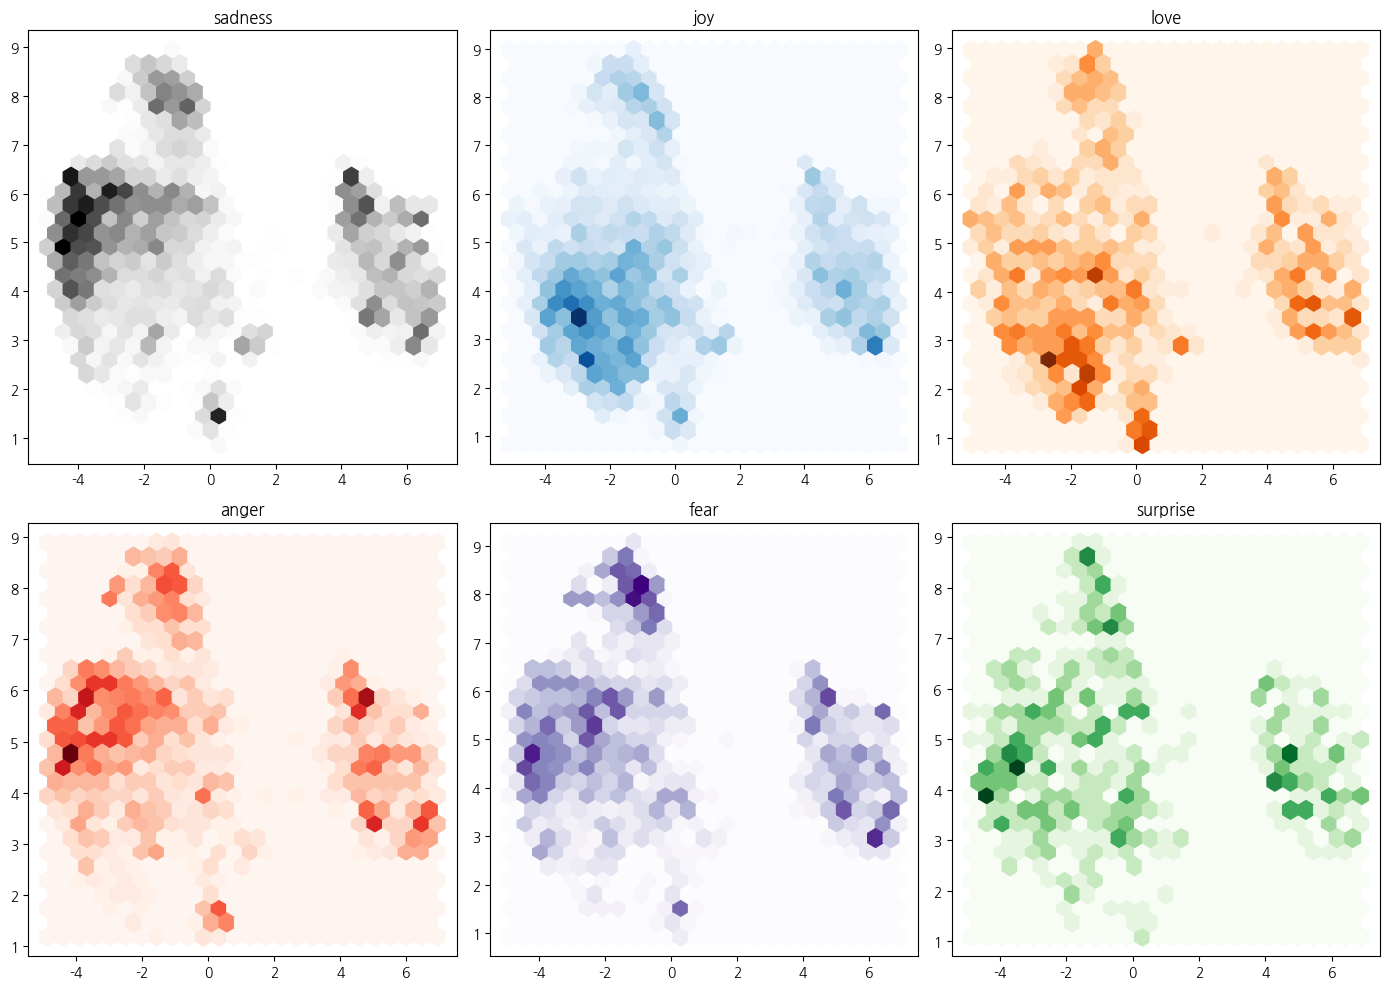

In [174]:
fig, ax = plt.subplots(2,3, figsize=(14,10))
ax = ax.flatten()

for i, ax_ in enumerate(ax):
    df_emb_choosen=df_emb[df_emb.label == i]
    ax_.hexbin(
        x=df_emb_choosen['x'],
        y=df_emb_choosen['y'],
        gridsize=25,
        cmap=cmaps[i]
        )
    ax_.set_title(labels[i])
plt.tight_layout()

- 분류시작

In [175]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform") # 무작위 일때 "uniform" : 0.165%, "most_frequent" : 0.352
dummy_clf.fit(x_train,y_train)
dummy_clf.score(x_valid,y_valid)

0.1745

- confusion_mat 확인

In [176]:
from sklearn import metrics

print(metrics.classification_report(y_valid, dummy_clf.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.28      0.17      0.21       550
           1       0.38      0.19      0.25       704
           2       0.07      0.15      0.10       178
           3       0.12      0.15      0.13       275
           4       0.10      0.15      0.12       212
           5       0.05      0.17      0.07        81

    accuracy                           0.17      2000
   macro avg       0.17      0.16      0.15      2000
weighted avg       0.25      0.17      0.19      2000



- 시각화 후 확인

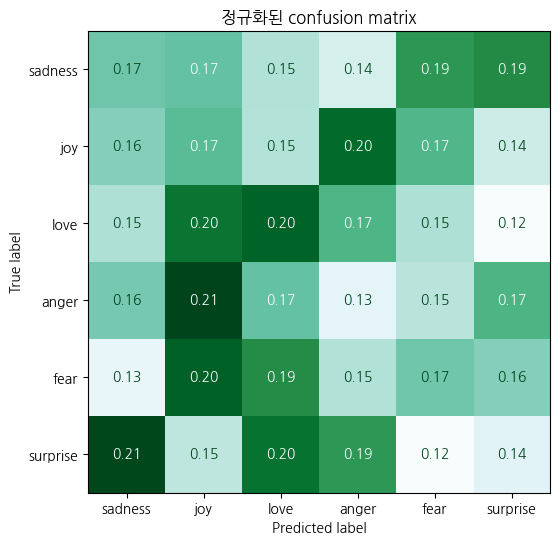

In [177]:
# 시각화 함수 정의
def plot_confusion_mat(y_preds,y_true,labels):
    cm = metrics.confusion_matrix(y_true,y_preds,normalize="true") # 정규화된 오차 행렬
    fig, ax = plt.subplots(figsize=(6,6))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuGn",
              values_format=".2f",
              colorbar=False,
              ax=ax)
    plt.title("정규화된 confusion matrix")
    return 


plot_confusion_mat(dummy_clf.predict(x_valid), y_valid, labels)

### distilBERT(End to End finetuning)
- 이때 head 부분은 미분이 가능해야함

In [178]:
from transformers import AutoModelForSequenceClassification # AutoModel와 달리 분류 헤드가 장착되어 있다.

num_labels=6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

- metric 정의

In [179]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels,preds)
    return {"accuracy" : acc, "f1" : f1} # 훈련 시 출력 형식 맞추기

- git 로그인

In [180]:
from huggingface_hub import notebook_login

notebook_login()

logging_steps = len(emotion_hiddenstate)

In [181]:
from transformers import TrainingArguments
batchsize = 64

log_step = len(emotion_hiddenstate['train'])//batchsize
model_name=f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batchsize,
                                  per_device_train_batch_size=batchsize,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=log_step,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [182]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_hiddenstate["train"],
                  eval_dataset = emotion_hiddenstate["validation"],
                  tokenizer=tokenizer)

trainer.train()

/tmp/ipykernel_1319/3502619010.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.852100,0.324885,0.909000,0.908662
2,0.268600,0.235302,0.925000,0.925035


TrainOutput(global_step=500, training_loss=0.5603603515625, metrics={'train_runtime': 162.3848, 'train_samples_per_second': 197.063, 'train_steps_per_second': 3.079, 'total_flos': 720342861696000.0, 'train_loss': 0.5603603515625, 'epoch': 2.0})

- metrics 확인

In [183]:
pred_out = trainer.predict(emotion_hiddenstate['validation'])
pred_out.metrics

{'test_loss': 0.23530156910419464,
 'test_accuracy': 0.925,
 'test_f1': 0.9250345463096841,
 'test_runtime': 2.2349,
 'test_samples_per_second': 894.911,
 'test_steps_per_second': 14.319}

In [184]:
y_preds = np.argmax(pred_out.predictions, axis=1)
y_preds

array([0, 0, 2, ..., 1, 2, 1])

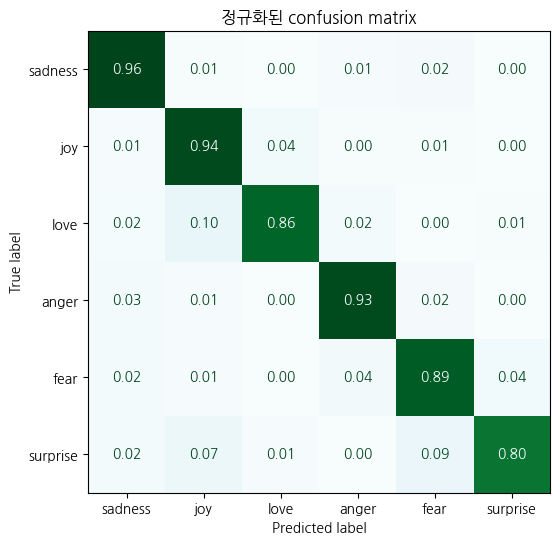

In [185]:
plot_confusion_mat(y_preds, y_valid, labels)

- 소요 리소스 확인
    ![resorce_check](images/02_01.png)

In [186]:
from torch.nn.functional import cross_entropy

def forward_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output=model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits.to(device), batch["label"].to(device), reduction="none")

    return {"loss":loss, "predict_label":pred_label.cpu().numpy()}

In [187]:
emotion_hiddenstate.set_format("torch",
                               columns=["input_ids","attention_mask","label"])

In [188]:
emotion_hiddenstate["validation"] = emotion_hiddenstate["validation"].map(forward_label, batched=True, batch_size=128)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [189]:
emotion_hiddenstate.set_format("pandas")
cols = ["text","label","predict_label","loss"]

In [ ]:
# 높은 loss 순으로 text 확인하기
df_valid = emotion_hiddenstate["validation"][:][cols]
df_valid['label'] = df_valid.label.map(lambda x:labels[x])
df_valid['predict_label'] = df_valid.predict_label.map(lambda x:labels[x])
df_valid.sort_values("loss",ascending=False).head(5)

,text,label,predict_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.667962
1274,i am going to several holiday parties and i ca...,joy,sadness,5.361343
1801,i feel that he was being overshadowed by the s...,love,sadness,5.350199
465,i would eventually go in to these stores but i...,joy,fear,5.252307
1963,i called myself pro life and voted for perry w...,joy,sadness,5.073988


In [ ]:
df_valid.sort_values("loss",ascending=True).head(5)

,text,label,predict_label,loss
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.016226
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.016784
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.017053
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.017239
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.017257


In [236]:
trainer.push_to_hub(tags="classification", commit_message="트레이닝 완!")

CommitInfo(commit_url='https://huggingface.co/tommyjin/distilbert-base-uncased-finetuned-emotion/commit/a4ab5ee361f5f998f0648112700d4fbadf5a78df', commit_message='트레이닝 완!', commit_description='', oid='a4ab5ee361f5f998f0648112700d4fbadf5a78df', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tommyjin/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='tommyjin/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

### cf) keras로 훈련 시키기(예시)
```py
from transformers import TFAutoModelForSequenceClassification

tf_model=TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

# 데이터 변환 to TF dataset

tokenizer_columns = tokenizer.model_input_names
tf_train = emotion_hiddenstate["train"].to_tf_dataset(
    columns = tokenizer_columns,
    label_cols= ['label'],
    shuffle=True,
    batch_size=batchsize
)

tf_valid = emotion_hiddenstate["validation"].to_tf_dataset(
    columns = tokenizer_columns,
    label_cols= ['label'],
    shuffle=False,
    batch_size=batchsize
)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy



opti_ = Adam(learning_rate=5e-5)
loss_ = SparseCategoricalCrossentropy(from_logits=True)
metr_ = SparseCategoricalAccuracy()

tf_model.compile(
    optimizer = opti_ ,
    loss = loss_ ,
    metrics = metr_ ,
)

tf_model.fit(tf_train, validation_data=tf_valid, epochs=2)
```

### 직접 훈련한 모델 불러와서 사용 해보기(pipeline)

In [237]:
from transformers import pipeline

model_id = "tommyjin/distilbert-base-uncased-finetuned-emotion"
classfier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
test_text = "i like this book, this book is so interesting"
pred= classfier(test_text, return_all_scores = True)[0]
pred_pd = pd.DataFrame(pred)
pred_pd["label"] = labels

In [274]:
pred_pd

,label,score
0,sadness,0.008109
1,joy,0.916750
2,love,0.019364
3,anger,0.005686
4,fear,0.008014
5,surprise,0.042076


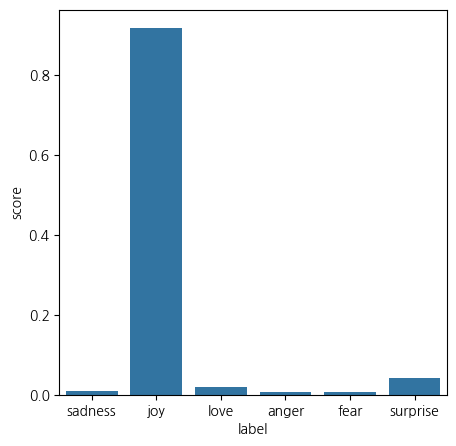

In [275]:
fig, ax = plt.subplots(figsize=(5,5))

sns.barplot(data=pred_pd,
            x='label',
            y='score', ax=ax);